# Contrastive Learning for Site Discovery

This notebook implements a PyTorch-based contrastive learning approach for site discovery recommendation.

**Problem**: Predict which sites a pilot will discover next based on their exploration history

**Approach**:
- **Training data**: Binary pilot-site interactions (visited or not)
- **Train/val/test split**: By pilots (each pilot in one split only)
- **Evaluation**: Walk-forward sequences simulating progressive discovery
  - For pilot visiting [S1, S2, S3, S4]: evaluate [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4

**Model**: Contrastive learning with InfoNCE loss
- Learn site embeddings through contrastive learning
- Query = centroid of history site embeddings
- Positive = next site to discover
- Negatives = randomly sampled unseen sites


In [1]:
import os
import logging
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Import our modules
from contrastive import (
    DiscoveryEpisodes, collate_episodes, DiscoveryModel, ContrastiveRecommender,
    train_discovery, set_global_seed
)
from process import (
    load_flight_data, get_first_visits, filter_pilots_and_sites,
    split_pilots, create_walk_forward_sequences, create_interaction_matrix,
    build_train_site_vocabulary
)
from metrics import evaluate_walk_forward, print_metrics_summary, aggregate_metrics
import plots
import utils


In [2]:
%load_ext autoreload
%autoreload 2


## 1. Setup and Load Data


In [3]:
# Database connection
load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)


In [4]:
# Load flight data
df = load_flight_data(engine)


2025-10-18 20:58:20,240 - process - INFO - Loading flight data...
2025-10-18 20:58:28,244 - process - INFO - Loaded 1,211,925 flights
2025-10-18 20:58:28,481 - process - INFO - Unique pilots: 31,311
2025-10-18 20:58:28,490 - process - INFO - Unique sites: 252
2025-10-18 20:58:28,590 - process - INFO - Date range: 2015-01-01 to 2024-12-31


## 2. Extract First Visits and Filter


In [5]:
# Get first visits (chronological order of site discovery per pilot)
first_visits = get_first_visits(df)

# Filter to active pilots and sites
filtered_visits = filter_pilots_and_sites(
    first_visits, 
    min_sites_per_pilot=3,  # Pilots who visited at least 3 sites
    min_pilots_per_site=5   # Sites visited by at least 5 pilots
)


2025-10-18 20:58:32,977 - process - INFO - First visits: 179,907
2025-10-18 20:58:33,038 - process - INFO - Pilots with visits: 31,311
2025-10-18 20:58:33,040 - process - INFO - Unique sites visited: 252
2025-10-18 20:58:33,327 - process - INFO - After filtering:
2025-10-18 20:58:33,381 - process - INFO -   Pilots: 18,921 (visited 3+ sites)
2025-10-18 20:58:33,385 - process - INFO -   Sites: 252 (visited by 5+ pilots)
2025-10-18 20:58:33,386 - process - INFO -   First visits: 162,795
2025-10-18 20:58:33,440 - process - INFO -   Sites per pilot - mean: 8.6, median: 6, max: 62


## 3. Split Data by Pilots


In [6]:
# Split pilots into train/val/test (each pilot appears in only one split)
train_df, val_df, test_df = split_pilots(
    filtered_visits,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)

2025-10-18 20:58:36,871 - process - INFO - 
Pilot-based split:
2025-10-18 20:58:36,872 - process - INFO -   Train: 13,244 pilots, 114,035 visits
2025-10-18 20:58:36,872 - process - INFO -   Val:   2,838 pilots, 24,700 visits
2025-10-18 20:58:36,873 - process - INFO -   Test:  2,839 pilots, 24,060 visits


## 4. Create Interaction Matrix and Mappings


In [7]:
# Create binary interaction matrix from training data
interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name = create_interaction_matrix(train_df)

# Build vocabulary of sites in training data
train_site_vocab = build_train_site_vocabulary(train_df)

print(f"Training data:")
print(f"  Pilots: {len(pilot_to_idx):,}")
print(f"  Sites: {len(site_to_idx):,}")
print(f"  Interactions: {interaction_matrix.nnz:,}")
print(f"  Density: {interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1]):.4f}")


2025-10-18 20:58:40,041 - process - INFO - 
Interaction matrix:
2025-10-18 20:58:40,042 - process - INFO -   Shape: 13244 pilots × 252 sites
2025-10-18 20:58:40,067 - process - INFO -   Density: 0.034168
2025-10-18 20:58:40,067 - process - INFO -   Total interactions: 114,035


Training data:
  Pilots: 13,244
  Sites: 252
  Interactions: 114,035
  Density: 0.0342


## 5. Create Training Episodes


In [8]:
# Create walk-forward sequences for training
train_episodes = create_walk_forward_sequences(train_df, min_history=1)

# Compute popularity weights from interaction matrix
pop_weights = np.asarray(interaction_matrix.sum(axis=0)).ravel()

print(f"Training episodes: {len(train_episodes):,}")
print(f"Popularity weights - min: {pop_weights.min():.1f}, max: {pop_weights.max():.1f}, mean: {pop_weights.mean():.1f}")


2025-10-18 20:58:47,299 - process - INFO - 
Created 100,791 walk-forward sequences
2025-10-18 20:58:47,332 - process - INFO -   From 13,244 pilots
2025-10-18 20:58:47,375 - process - INFO -   Avg sequences per pilot: 7.6


Training episodes: 100,791
Popularity weights - min: 38.0, max: 4678.0, mean: 452.5


## 6. Create Dataset and DataLoader


In [9]:
# Set global seed for reproducibility
set_global_seed(42)

# Create dataset
train_dataset = DiscoveryEpisodes(
    episodes=train_episodes,
    site_to_idx=site_to_idx,
    n_items=len(site_to_idx),
    k_neg=50,  # Number of negative samples per episode
    pop_weights=None, #pop_weights,
    hard_neighbors=None,  # Optional: hard negative neighbors
    hard_frac=0.2,  # Fraction of hard negatives
    seed=42
)

# Create data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_episodes,
    num_workers=0  # Set to 0 for Windows compatibility
)

print(f"Dataset size: {len(train_dataset):,}")
print(f"Batches per epoch: {len(train_loader):,}")

# Test a single batch to debug
print("\nTesting a single batch...")
for i, batch in enumerate(train_loader):
    histories_bag, pos, neg = batch
    flat, offsets = histories_bag
    print(f"Batch {i}: pos shape: {pos.shape}, neg shape: {neg.shape}, flat shape: {flat.shape}, offsets shape: {offsets.shape}")
    if i >= 2:  # Test first few batches
        break


Dataset size: 100,791
Batches per epoch: 394

Testing a single batch...
Batch 0: pos shape: torch.Size([256]), neg shape: torch.Size([256, 50]), flat shape: torch.Size([1733]), offsets shape: torch.Size([257])
Batch 1: pos shape: torch.Size([256]), neg shape: torch.Size([256, 50]), flat shape: torch.Size([1864]), offsets shape: torch.Size([257])
Batch 2: pos shape: torch.Size([256]), neg shape: torch.Size([256, 50]), flat shape: torch.Size([1812]), offsets shape: torch.Size([257])


## 7. Initialize Model and Optimizer


In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = DiscoveryModel(
    n_items=len(site_to_idx),
    dim=64  # Embedding dimension
).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Embedding size: {model.item_emb.weight.shape}")

Using device: cpu
Model parameters: 16,128
Embedding size: torch.Size([252, 64])


## 8. Training Loop


In [11]:
Ks = [3, 5, 10] # Ks for walk-forward evaluation

# Training parameters
epochs = 50
lr = 5e-3
weight_decay = 1e-4
tau = 0.1  # Temperature parameter
grad_clip = 1.0
add_inbatch_neg = False  # Disable in-batch negatives to fix tensor size mismatch
l2_reg = 0.0
use_amp = False

# Train the model using the new training function
print("Starting training...")
trained_model = train_discovery(
    model=model,
    loader=train_loader,
    epochs=epochs,
    lr=lr,
    weight_decay=weight_decay,
    tau=tau,
    device=device,
    grad_clip=grad_clip,
    add_inbatch_neg=add_inbatch_neg,
    l2_reg=l2_reg,
    use_amp=use_amp
)

print("Training completed!")

Starting training...


/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/site_to_site/contrastive.py:280: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.startswith("cuda")))
2025-10-18 20:59:29,701 - contrastive - INFO - [epoch 1] loss=2.3452
2025-10-18 20:59:45,185 - contrastive - INFO - [epoch 2] loss=2.2222
2025-10-18 21:00:06,644 - contrastive - INFO - [epoch 3] loss=2.2009
2025-10-18 21:00:29,279 - contrastive - INFO - [epoch 4] loss=2.1936
2025-10-18 21:00:48,302 - contrastive - INFO - [epoch 5] loss=2.1844
2025-10-18 21:01:05,947 - contrastive - INFO - [epoch 6] loss=2.1819
2025-10-18 21:01:23,633 - contrastive - INFO - [epoch 7] loss=2.1753
2025-10-18 21:01:40,324 - contrastive - INFO - [epoch 8] loss=2.1733
2025-10-18 21:01:56,893 - contrastive - INFO - [epoch 9] loss=2.1709
2025-10-18 21:02:14,191 - contrastive - INFO - [epoch 10] loss=2.1669
20

Training completed!


## 9. Create Recommender Wrapper


In [12]:
# Wrap trained model for evaluation
recommender = ContrastiveRecommender(
    model=trained_model,
    site_to_idx=site_to_idx,
    idx_to_site=idx_to_site,
    site_id_to_name=site_id_to_name,
    device=device
)

print("ContrastiveRecommender created successfully!")
print(f"Embedding shape: {recommender._item_embeddings.shape}")


ContrastiveRecommender created successfully!
Embedding shape: (252, 64)


## 10. Create Validation Sequences


In [13]:
# Create validation sequences
val_sequences = create_walk_forward_sequences(val_df, min_history=1)

print(f"Validation sequences: {len(val_sequences):,}")
print(f"From {val_df['pilot'].nunique():,} validation pilots")


2025-10-18 21:15:55,075 - process - INFO - 
Created 21,862 walk-forward sequences
2025-10-18 21:15:55,081 - process - INFO -   From 2,838 pilots
2025-10-18 21:15:55,085 - process - INFO -   Avg sequences per pilot: 7.7


Validation sequences: 21,862
From 2,838 validation pilots


## 11. Evaluate on Validation Set


In [14]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_metrics = evaluate_walk_forward(
    recommender,
    val_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 21:16:00,713 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 21:16:00,744 - metrics - INFO - Evaluating 21,862 valid sequences (out of 21,862)


Evaluating on validation set...


100%|███████████████████████████████████████████████████████████████████████████| 21862/21862 [00:03<00:00, 7084.40it/s]
2025-10-18 21:16:03,838 - metrics - INFO - 
2025-10-18 21:16:03,839 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 21:16:03,842 - metrics - INFO - ============================================================
2025-10-18 21:16:03,843 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 21:16:03,846 - metrics - INFO -   Hit Rate@3:  0.3072
2025-10-18 21:16:03,848 - metrics - INFO -   MRR:           0.2579
2025-10-18 21:16:03,850 - metrics - INFO -   NDCG@3:      0.2368
2025-10-18 21:16:03,851 - metrics - INFO -   Coverage@3:  0.9762 (246/252 sites)
2025-10-18 21:16:03,852 - metrics - INFO -   Avg Log-Pop@3: 6.9676
2025-10-18 21:16:03,853 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 21:16:03,855 - metrics - INFO -   Hit Rate@5:  0.4108
2025-10-18 21:16:03,861 - metrics - INFO -   MRR:           0.2579
2025-10-18 21:16:03,866 - metrics - INFO -   NDCG@5:      0.2

## 12. Create Test Sequences


In [15]:
# Create test sequences
test_sequences = create_walk_forward_sequences(test_df, min_history=1)

print(f"Test sequences: {len(test_sequences):,}")
print(f"From {test_df['pilot'].nunique():,} test pilots")


2025-10-18 21:16:10,834 - process - INFO - 
Created 21,221 walk-forward sequences
2025-10-18 21:16:10,839 - process - INFO -   From 2,839 pilots
2025-10-18 21:16:10,851 - process - INFO -   Avg sequences per pilot: 7.5


Test sequences: 21,221
From 2,839 test pilots


## 13. Evaluate on Test Set


In [16]:
# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_walk_forward(
    recommender,
    test_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 21:16:17,682 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 21:16:17,730 - metrics - INFO - Evaluating 21,221 valid sequences (out of 21,221)


Evaluating on test set...


100%|███████████████████████████████████████████████████████████████████████████| 21221/21221 [00:03<00:00, 6105.10it/s]
2025-10-18 21:16:21,214 - metrics - INFO - 
2025-10-18 21:16:21,215 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 21:16:21,216 - metrics - INFO - ============================================================
2025-10-18 21:16:21,216 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 21:16:21,218 - metrics - INFO -   Hit Rate@3:  0.3154
2025-10-18 21:16:21,222 - metrics - INFO -   MRR:           0.2659
2025-10-18 21:16:21,231 - metrics - INFO -   NDCG@3:      0.2444
2025-10-18 21:16:21,231 - metrics - INFO -   Coverage@3:  0.9722 (245/252 sites)
2025-10-18 21:16:21,235 - metrics - INFO -   Avg Log-Pop@3: 6.9301
2025-10-18 21:16:21,236 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 21:16:21,238 - metrics - INFO -   Hit Rate@5:  0.4224
2025-10-18 21:16:21,247 - metrics - INFO -   MRR:           0.2659
2025-10-18 21:16:21,250 - metrics - INFO -   NDCG@5:      0.2

## 14. Visualize Results


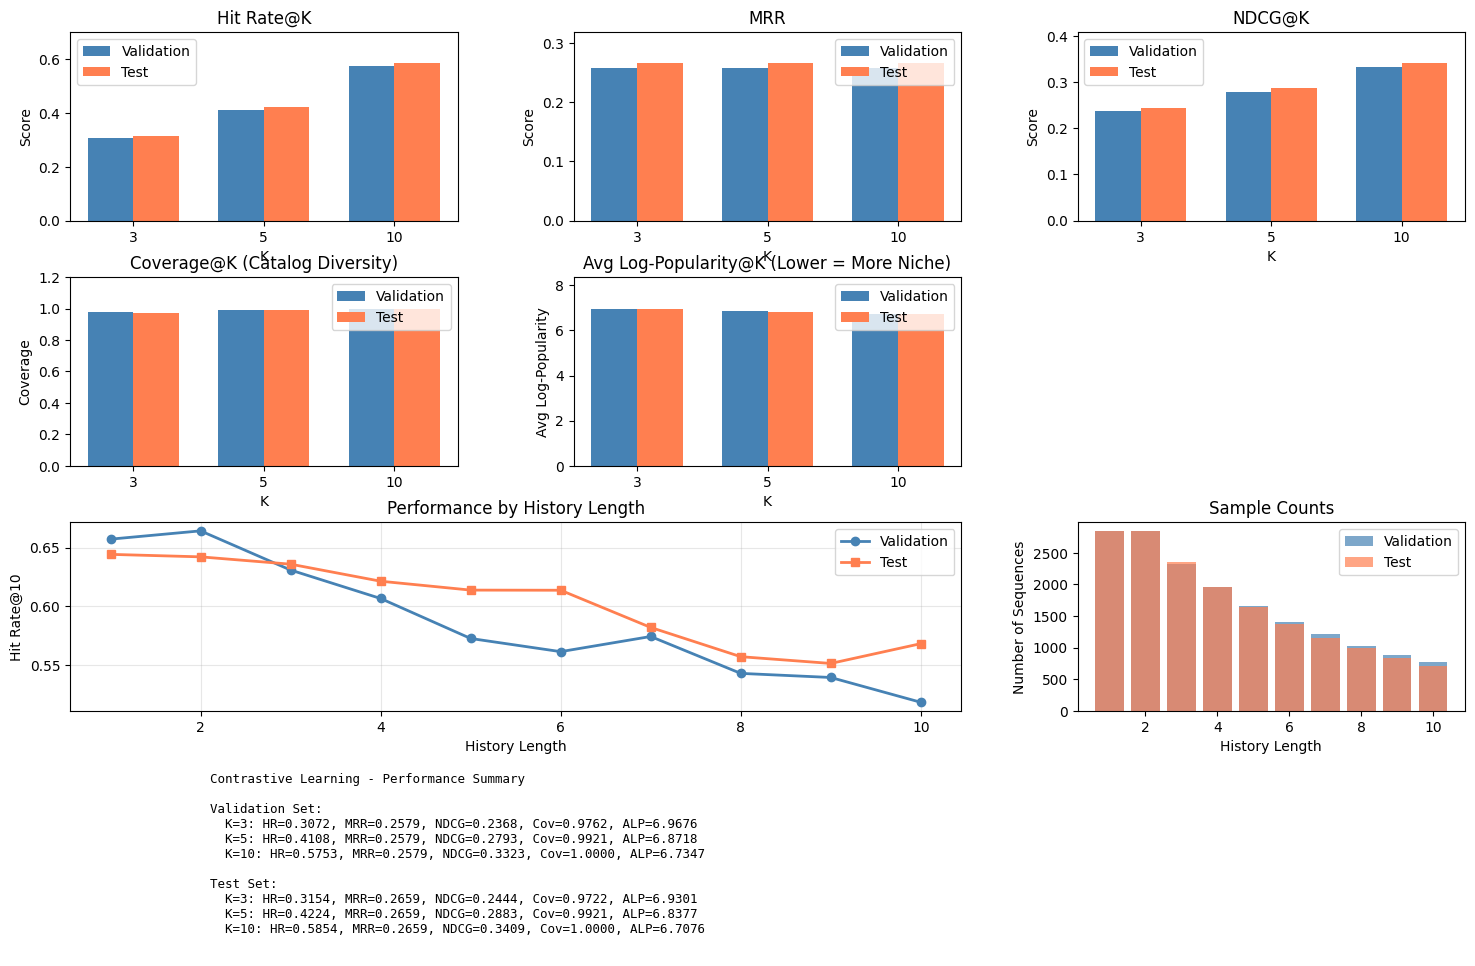

In [17]:
# Create comprehensive results dashboard
fig = plots.create_results_dashboard(
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    model_name='Contrastive Learning',
    k_values=Ks
)

plt.show()


## 15. Sample Recommendations


In [91]:
# Show sample recommendations
print("Sample recommendations from validation set:")
utils.print_sample_sequence(val_sequences[100], recommender, top_k=10)


Sample recommendations from validation set:
Pilot's history: ['Bassano', 'Mieroszów']
Actual next site: Černá hora (ID: 4)

Top 10 recommendations:
  1. Černá hora: 0.7137 ← TARGET
  2. Kobala: 0.6784
  3. Meduno: 0.6443
  4. Lijak: 0.6384
  5. Col Rodella: 0.6274
  6. Feltre: 0.6075
  7. Andrzejowka: 0.6042
  8. Revine: 0.5980
  9. Skrzyczne: 0.5681
  10. Monte Dolada: 0.5347


## 16. Similar Sites Analysis


In [ ]:
# Show similar sites for a popular site
popular_sites = ['Bassano', 'Kobala', 'Cornizzolo']

for site_name in popular_sites:
    # Find site_id for this name
    site_id = None
    for sid, name in site_id_to_name.items():
        if name == site_name:
            site_id = sid
            break
    
    if site_id:
        print(f"\nSimilar sites to {site_name}:")
        similar = recommender.get_similar_sites(site_id, top_k=5)
        for i, (sid, name, score) in enumerate(similar, 1):
            print(f"  {i}. {name}: {score:.4f}")
    else:
        print(f"Site {site_name} not found in training data")



Similar sites to Bassano:
  1. Kobala: 0.7663
  2. Col Rodella: 0.7660
  3. Feltre: 0.7448
  4. Meduno: 0.7241
  5. Emberger Alm: 0.7066

Similar sites to Kobala:
  1. Lijak: 0.8853
  2. Bassano: 0.7663
  3. Stol: 0.7655
  4. Emberger Alm: 0.7202
  5. Meduno: 0.7019

Similar sites to Cornizzolo:
  1. Giumello: 0.7107
  2. Valcava: 0.6832
  3. Santa Elisabetta: 0.6532
  4. Laveno: 0.6224
  5. Cavallaria: 0.6119

Similar sites to Kozákov:
  1. Černá hora: 0.6918
  2. Zvičina: 0.6447
  3. Rašovka: 0.6271
  4. Zásada: 0.6170
  5. Raná: 0.5398


In [96]:
recommender.get_recommendations([205, 133, 202, 225], top_k=10)

[(185, 'Col de La Forclaz', 0.68961501121521),
 (186, 'Saint Hilaire', 0.6347090601921082),
 (238, 'Loarre', 0.6268199682235718),
 (221, 'Poniente', 0.6099242568016052),
 (216, 'Mauroux', 0.588909387588501),
 (197, 'Millau', 0.5888734459877014),
 (223, 'Peña Negra', 0.5855886936187744),
 (188, 'Planfait', 0.5689419507980347),
 (187, 'St. André', 0.5661348104476929),
 (191, 'Planpraz', 0.5608410835266113)]

## 17. Save Model


In [ ]:
# Save the trained model
model_path = "contrastive_model.pth"
recommender.save(model_path)

print(f"Model saved to {model_path}")

# Test loading
loaded_recommender = ContrastiveRecommender.load(model_path, device=device)
print("Model loaded successfully!")

# Verify it works
test_recs = loaded_recommender.get_recommendations([list(site_to_idx.keys())[0]], top_k=3)
print(f"Test recommendations: {len(test_recs)} items")

2025-10-18 21:16:54,153 - contrastive - INFO - Saved ContrastiveRecommender to contrastive_model.pth
/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/site_to_site/contrastive.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an iss

Model saved to contrastive_model.pth
Model loaded successfully!
Test recommendations: 3 items


In [101]:
site_embeddings = recommender._item_embeddings

In [105]:
site_embeddings.shape

(252, 64)

In [ ]:
import pickle

# Save the EMBEDDINGS dictionary to a pickle file
EMBEDDINGS = {
    "matrix": recommender._item_embeddings,
    "site_to_idx": recommender.site_to_idx,
    "idx_to_site": recommender.idx_to_site,
}

with open("s2s_covisit_embeddings.pkl", "wb") as f:
    pickle.dump(EMBEDDINGS, f)